This script investigates the influence of different audio data representations in dimensionality reduction and clustering on a dataset of goose vocalizations.

In [371]:
# TODO: exchange librosa completely with maad?
import glob
import librosa
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
import seaborn as sns
from maad import features, rois, sound
from maad.util import (power2dB, plot_shape)
import random

In [372]:
random.seed(42)

In [373]:
DATAPATH = "/Users/lenagies/Desktop/Master/Thesis/geese/data/clips_from_selections"
clip_paths = glob.glob(DATAPATH+"/*.wav")

In [374]:
len(clip_paths)

7409

Inspect single call

In [375]:
i = 1300
n_fft = 512
hop_overlap = 9
top_db_silence = 35

In [376]:
call, sr = librosa.load(clip_paths[i], sr=None)

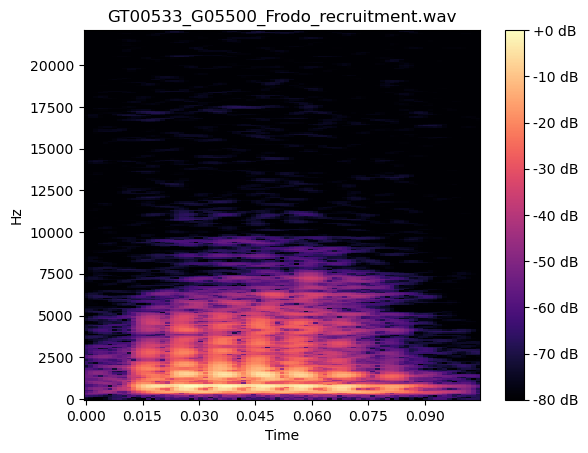

In [377]:
fig, ax = plt.subplots()
img = librosa.display.specshow(librosa.amplitude_to_db(np.abs(librosa.stft(call, n_fft=n_fft, hop_length=(n_fft//hop_overlap))), ref=np.max), sr=sr, hop_length=(n_fft//hop_overlap), x_axis='time', y_axis='linear', ax=ax)
ax.set(title=clip_paths[i].split("/")[-1])
fig.colorbar(img, ax=ax, format="%+2.f dB")

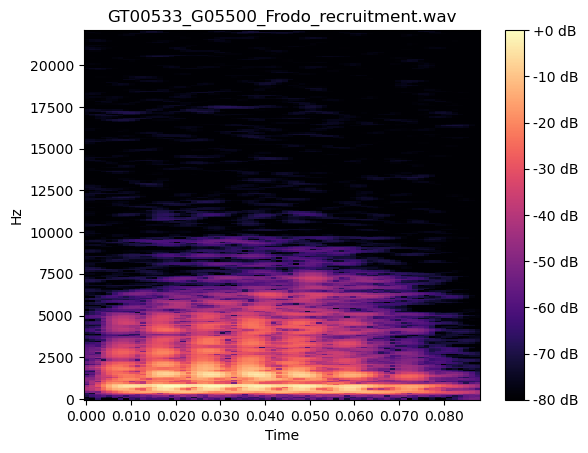

In [378]:
# trim trailing silences using db threshold, discard second entry, that holds indices
fig, ax = plt.subplots()
img = librosa.display.specshow(librosa.amplitude_to_db(np.abs(librosa.stft(librosa.effects.trim(call, top_db=top_db_silence, frame_length=n_fft, hop_length=(n_fft//hop_overlap))[0], n_fft=n_fft, hop_length=(n_fft//hop_overlap))), ref=np.max), sr=sr, hop_length=(n_fft//hop_overlap), x_axis='time', y_axis='linear', ax=ax)
ax.set(title=clip_paths[i].split("/")[-1])
fig.colorbar(img, ax=ax, format="%+2.f dB")

min max normalization: 
$X = \frac{X - X_{min}}{X_{max} - X_{min}}$

#### Process clips and write to dataframe
- trim
- normalize 

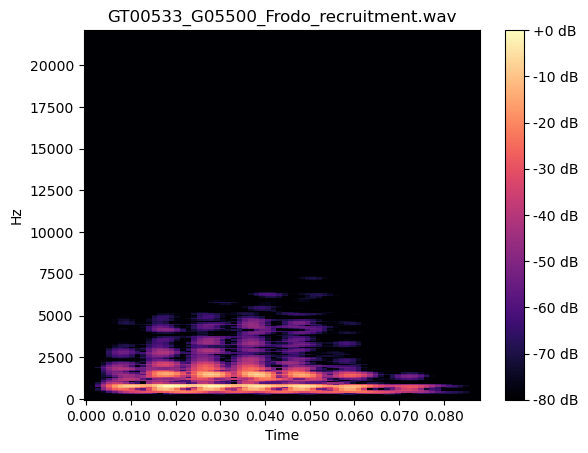

In [379]:
def min_max_scale(waveform):
    # Normalizes Spectrogram to values between 0 and 1
    return (waveform - waveform.min()) / (waveform.max() - waveform.min())
    
def peak_normalization(waveform):
    # from biosound package: https://github.com/theunissenlab/BioSoundTutorial/blob/master/BioSound1.ipynb
    return np.array((waveform / np.max(np.abs(waveform))), np.float32)

trimmed_call = librosa.effects.trim(call, top_db=top_db_silence, frame_length=n_fft, hop_length=(n_fft//hop_overlap))[0]
normalized_call = peak_normalization(trimmed_call)
spec = np.abs(librosa.stft(normalized_call, n_fft=n_fft, hop_length=(n_fft//hop_overlap)))
spec_db = librosa.amplitude_to_db(spec**2, ref=np.max)
fig, ax = plt.subplots()
#img = ax.matshow(spec_db, origin="lower", cmap="viridis")
img = librosa.display.specshow(spec_db, sr=sr, n_fft=n_fft, hop_length=(n_fft//hop_overlap), x_axis='time', y_axis='linear', ax=ax)
ax.set(title=clip_paths[i].split("/")[-1])
fig.colorbar(img, ax=ax, format="%+2.f dB")

Read sound files into dataframe and preprocess inside loop:
- Trim silences
- Normalize

In [380]:
calls_df = pd.DataFrame(columns=["track_ID", "clip_ID", "goose_ID", "call_type", "waveform", "sr"])
for clip_path in tqdm(clip_paths):
    waveform, sr = librosa.load(clip_path, sr=None)
    trimmed_waveform = librosa.effects.trim(waveform, top_db=top_db_silence, frame_length=n_fft, hop_length=(n_fft//hop_overlap))[0]
    normalized_waveform = peak_normalization(trimmed_waveform)
    filename = clip_path.split("/")[-1].split(".")[0]
    calls_df.loc[len(calls_df)] = [filename.split("_")[0], filename.split("_")[1], filename.split("_")[2], filename.split("_")[3], normalized_waveform, sr]

  0%|          | 0/7409 [00:00<?, ?it/s]

/var/folders/kl/qgqbw3bd42bf_tybhvnz9vxh0000gn/T/ipykernel_57718/1014906333.py:7: RuntimeWarning: invalid value encountered in divide
  return np.array((waveform / np.max(np.abs(waveform))), np.float32)
/var/folders/kl/qgqbw3bd42bf_tybhvnz9vxh0000gn/T/ipykernel_57718/1014906333.py:7: RuntimeWarning: invalid value encountered in divide
  return np.array((waveform / np.max(np.abs(waveform))), np.float32)
/var/folders/kl/qgqbw3bd42bf_tybhvnz9vxh0000gn/T/ipykernel_57718/1014906333.py:7: RuntimeWarning: invalid value encountered in divide
  return np.array((waveform / np.max(np.abs(waveform))), np.float32)
/var/folders/kl/qgqbw3bd42bf_tybhvnz9vxh0000gn/T/ipykernel_57718/1014906333.py:7: RuntimeWarning: invalid value encountered in divide
  return np.array((waveform / np.max(np.abs(waveform))), np.float32)
/var/folders/kl/qgqbw3bd42bf_tybhvnz9vxh0000gn/T/ipykernel_57718/1014906333.py:7: RuntimeWarning: invalid value encountered in divide
  return np.array((waveform / np.max(np.abs(waveform))

In [381]:
len(calls_df)

7409

In [382]:
calls_df['length'] = calls_df.apply(lambda row: len(row['waveform']) / row['sr'], axis=1)
calls_df['log(length)'] = calls_df.apply(lambda row: np.log(row['length']), axis=1)
calls_df.head()

,track_ID,clip_ID,goose_ID,call_type,waveform,sr,length,log(length)
0,GT00780,G11666,Lando,recruitment,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",44100,0.102857,-2.274414
1,GT00772,G11510,Burglar,recruitment,"[-0.00084985833, 0.00084985833, 0.0028328612, ...",44100,0.100998,-2.292657
2,GT00795,G11994,EinStein,contact,"[0.004903678, 0.0052539404, 0.0038528896, 0.00...",44100,0.092698,-2.378404
3,GT00447,G04128,BruceSpringsteen,departure,"[0.00017799929, -0.00035599858, -0.001245995, ...",44100,0.160385,-1.830175
4,GT00775,G11567,Anthony,recruitment,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.00143884...",44100,0.088889,-2.420368


/var/folders/kl/qgqbw3bd42bf_tybhvnz9vxh0000gn/T/ipykernel_57718/1510808998.py:4: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  hist = sns.histplot(


[]

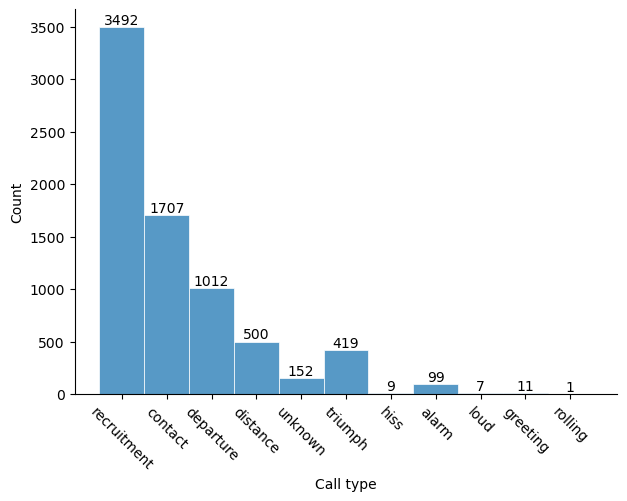

In [383]:
f, ax = plt.subplots(figsize=(7, 5))
sns.despine(f)

hist = sns.histplot(
    calls_df,
    x="call_type",
    multiple="stack",
    palette="viridis",
    edgecolor="1",
    linewidth=.5,
)

plt.xticks(rotation=-45)
ax.set_xlabel("Call type")

# Add counts
for p in hist.patches:
    height = p.get_height()
    x = p.get_x() + p.get_width() / 2
    ax.annotate(f'{int(height)}', (x, height), ha='center', va='bottom')
    
plt.plot()

/var/folders/kl/qgqbw3bd42bf_tybhvnz9vxh0000gn/T/ipykernel_57718/799454026.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
 [Text(0, 0, 'recruitment'),
  Text(1, 0, 'contact'),
  Text(2, 0, 'departure'),
  Text(3, 0, 'distance'),
  Text(4, 0, 'unknown'),
  Text(5, 0, 'triumph'),
  Text(6, 0, 'hiss'),
  Text(7, 0, 'alarm'),
  Text(8, 0, 'loud'),
  Text(9, 0, 'greeting'),
  Text(10, 0, 'rolling')])

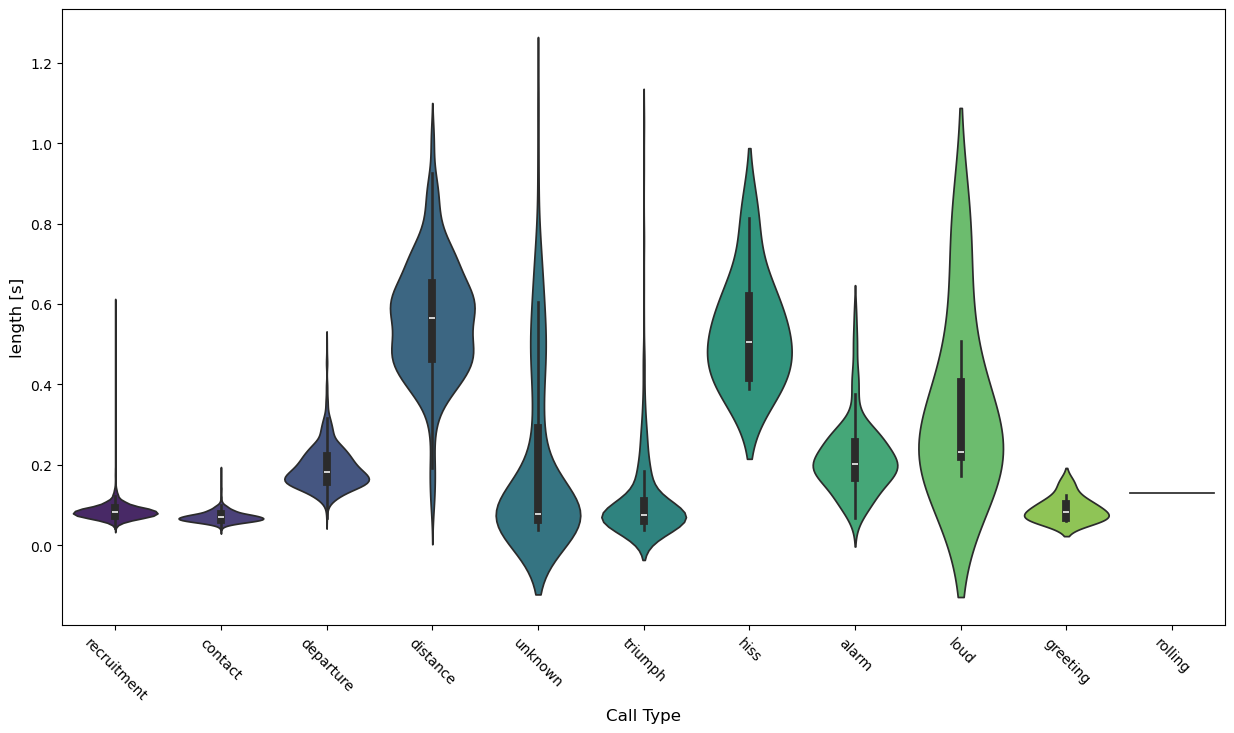

In [384]:
plt.figure(figsize=(15, 8))
sns.violinplot(
    data=calls_df,
    x="call_type",
    y="length",
    palette="viridis",
    density_norm="width" 
)

plt.xlabel("Call Type", fontsize=12)
plt.ylabel("length [s]", fontsize=12)
plt.xticks(rotation=-45)

[]

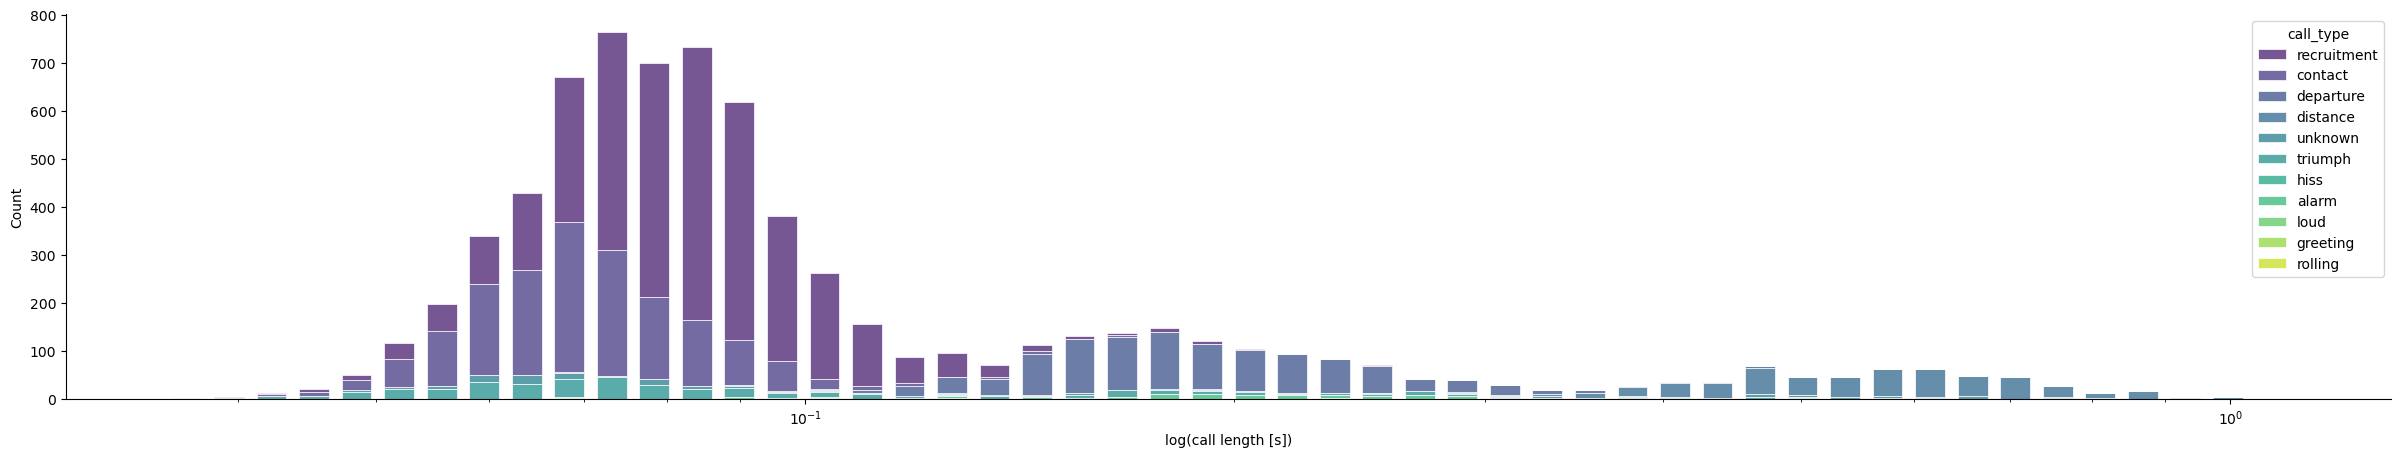

In [385]:
f, ax = plt.subplots(figsize=(30, 5))
sns.despine(f)

sns.histplot(
    calls_df,
    x="length",
    multiple="stack",
    hue="call_type",
    palette="viridis",
    edgecolor="1",
    linewidth=.5,
    shrink=.7,
    bins=50,
    log_scale=True
)
ax.set_xlabel("log(call length [s])")
plt.plot()

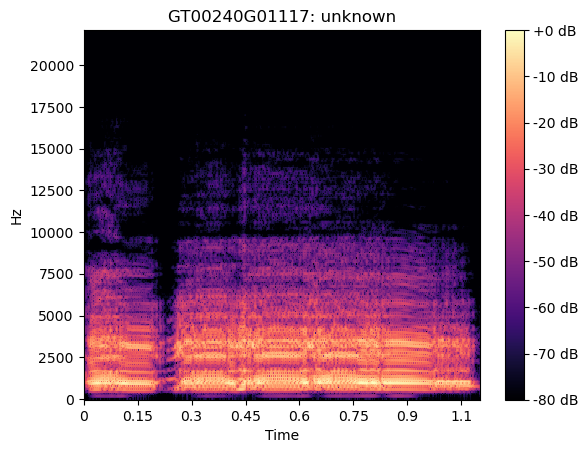

In [386]:
# longest call
call = calls_df.loc[calls_df['length'].idxmax()]
# random call
#call = calls_df.iloc()[np.random.randint(0, len(calls_df))]


fig, ax = plt.subplots()
img = librosa.display.specshow(librosa.amplitude_to_db(np.abs(librosa.stft(call["waveform"], n_fft = n_fft, hop_length=(n_fft//hop_overlap))), ref=np.max), x_axis='time', y_axis='linear', ax=ax, sr=call["sr"], n_fft=n_fft, hop_length=(n_fft//hop_overlap))
ax.set(title=call["track_ID"]+call["clip_ID"]+": "+call["call_type"])
fig.colorbar(img, ax=ax, format="%+2.f dB")

In [387]:
call

track_ID                                                 GT00240
clip_ID                                                   G01117
goose_ID                                                Erdbeere
call_type                                                unknown
waveform       [0.0015316448, 0.0016957497, 0.0018051529, 0.0...
sr                                                         44100
length                                                  1.103492
log(length)                                              0.09848
Name: 743, dtype: object

In [543]:
def pad_to_length(signal, ratio, target_length):
    signal_length = int(ratio * target_length)
    padding_total = target_length - signal_length 
    padding_before = padding_total // 2
    padding_after = padding_total - padding_before
    padded_waveform = np.pad(signal, (padding_before, padding_after), mode='constant')
    return librosa.util.fix_length(padded_waveform, size=target_length) #cut any rounding errors

def log_scale_padding(calls_df):
    # get log of longest call to calculate bin ratio
    max_log_length = calls_df.loc[calls_df["length"].idxmax()]["log(length)"]
    min_log_length = calls_df.loc[calls_df["length"].idxmin()]["log(length)"]
    target_length = int(0.5*sr)

    print(calls_df.loc[calls_df["normalized_log_length"].idxmax()]["normalized_log_length"])
    print(calls_df.loc[calls_df["normalized_log_length"].idxmin()]["normalized_log_length"])
    
    # min max normalization
    calls_df["normalized_log_length"] = calls_df.apply(lambda row: (row["log(length)"]-min_log_length)/(max_log_length-min_log_length), axis=1)
    calls_df["target_length"] = calls_df.apply(lambda row: np.exp(row["normalized_log_length"]), axis=1)
    calls_df["padded_signal"] = calls_df.apply(lambda row: pad_to_length(row["waveform"], row["normalized_log_length"], target_length), axis=1)
    calls_df["padded_signal_array_length"] = calls_df.apply(lambda row: len(row["padded_signal"]), axis=1)

In [544]:
log_scale_padding(calls_df)

1.0
0.0


In [492]:
calls_df.head()

,track_ID,clip_ID,goose_ID,call_type,waveform,sr,length,log(length),normalized_log_length,target_length,padded_signal,padded_signal_array_length
0,GT00780,G11666,Lando,recruitment,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",44100,0.102857,-2.274414,0.309229,1.362374,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",22050
1,GT00772,G11510,Burglar,recruitment,"[-0.00084985833, 0.00084985833, 0.0028328612, ...",44100,0.100998,-2.292657,0.303918,1.355158,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",22050
2,GT00795,G11994,EinStein,contact,"[0.004903678, 0.0052539404, 0.0038528896, 0.00...",44100,0.092698,-2.378404,0.278957,1.321750,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",22050
3,GT00447,G04128,BruceSpringsteen,departure,"[0.00017799929, -0.00035599858, -0.001245995, ...",44100,0.160385,-1.830175,0.438551,1.550459,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",22050
4,GT00775,G11567,Anthony,recruitment,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.00143884...",44100,0.088889,-2.420368,0.266741,1.305702,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",22050


[]

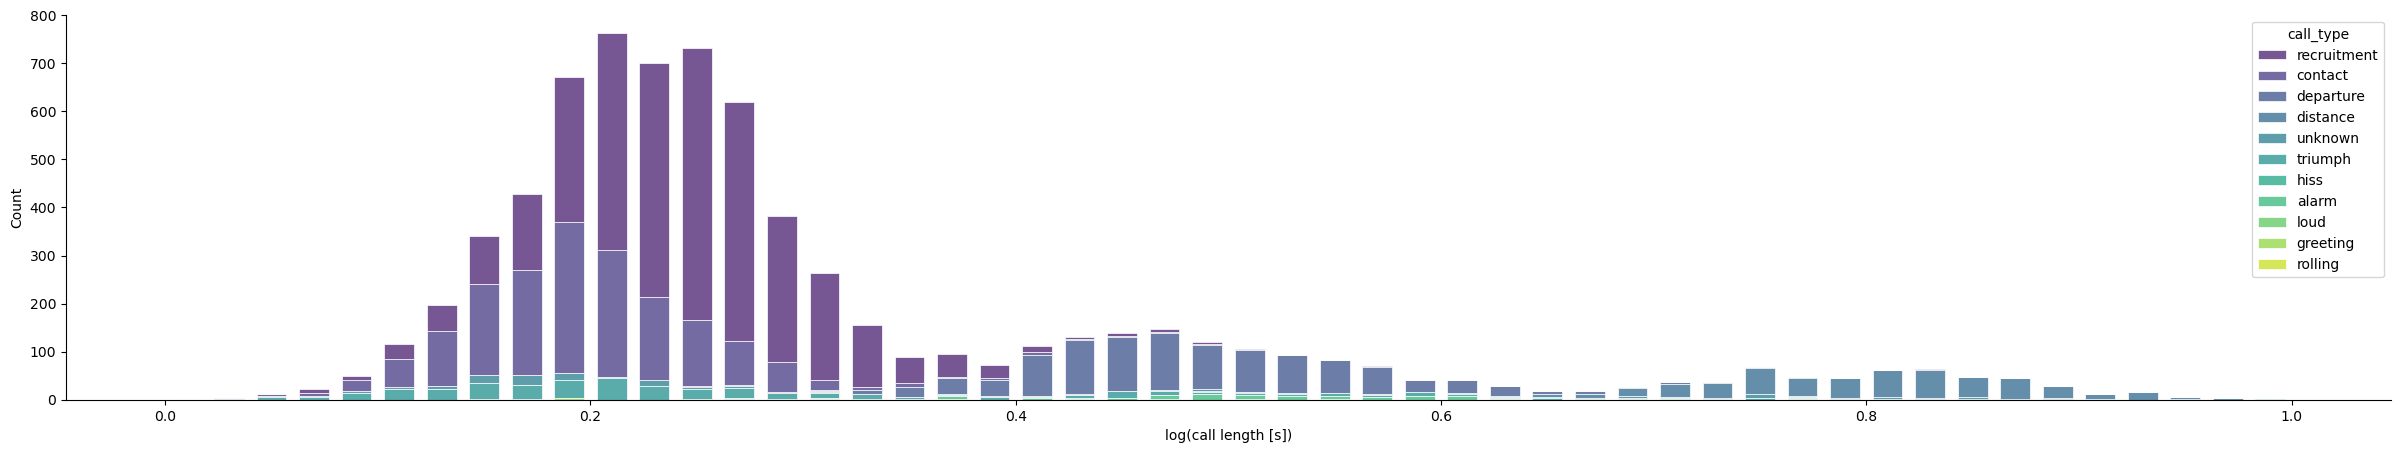

In [493]:
f, ax = plt.subplots(figsize=(30, 5))
sns.despine(f)

sns.histplot(
    calls_df,
    x="normalized_log_length",
    multiple="stack",
    hue="call_type",
    palette="viridis",
    edgecolor="1",
    linewidth=.5,
    shrink=.7,
    bins=50,
)
ax.set_xlabel("log(call length [s])")
plt.plot()

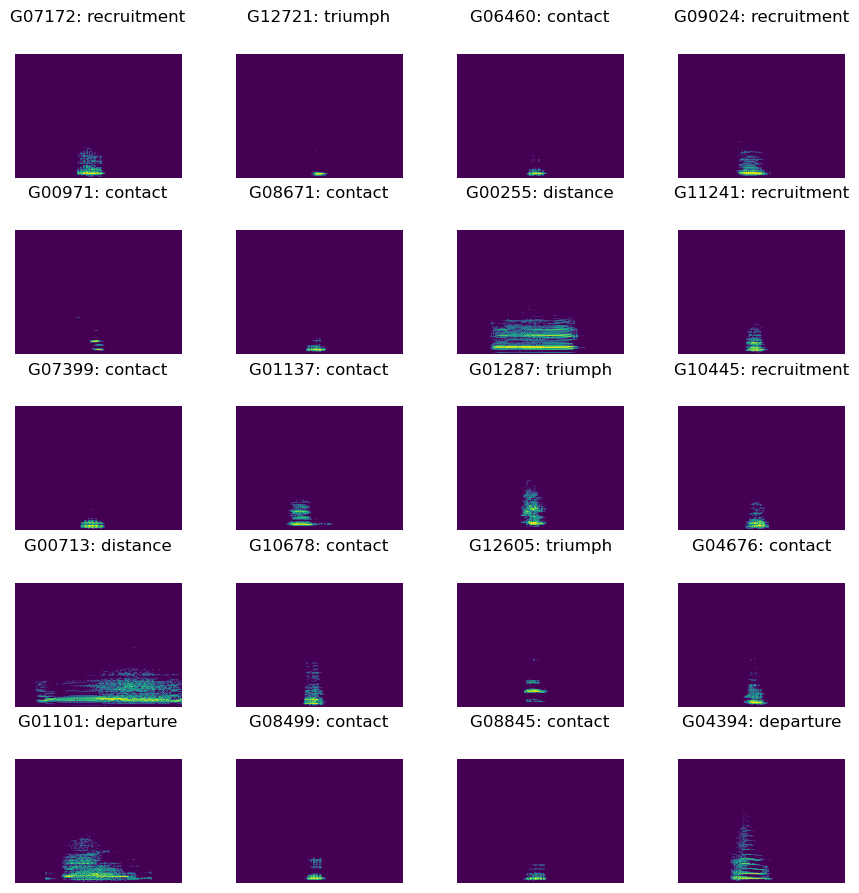

In [494]:
# plot a random sample of 20 calls

sample_indices = random.sample(range(len(calls_df)), 20)
sample_calls = calls_df.loc[sample_indices]

fig, axes = plt.subplots(5, 4, figsize=(9, 9))

for i, (_, call) in enumerate(sample_calls.iterrows()):
    row = i // 4
    col = i % 4
    spec = librosa.stft(call["padded_signal"], n_fft=512, hop_length=(512 // 8))
    spec_db = librosa.amplitude_to_db(np.abs(spec)**2, ref=np.max)
    axes[row, col].matshow(spec_db, origin="lower", cmap="viridis")
    axes[row, col].set_title(f"{call['clip_ID']}: {call['call_type']}", )
    axes[row, col].axis("off") 
    
for i in range(len(sample_calls), 20):
  row = i // 4
  col = i % 4
  axes[row, col].axis("off")

plt.tight_layout()
plt.show()

##### Extract audio features using **scikit maad**: 

*Ulloa, J. S., Haupert, S., Latorre, J. F., Aubin, T., & Sueur, J. (2021). scikit-maad: An open-source and modular toolbox for quantitative soundscape analysis in Python. Methods in Ecology and Evolution, 2041-210X.13711. https://doi.org/10.1111/2041-210X.13711*

**Temporal features:**
- sm: temporal mean of waveform
- sv: temporal variance of waveform
- ss: temporal skewness of waveform
- sk: temporal kurtosis of waveform
- time #%: temporal quantile of waveform
- zcr: Zero crossing rate of waveform
- duration_50/90: temporal duration of waveform

In [393]:
features.all_temporal_features(call["waveform"], call["sr"])

,sm,sv,ss,sk,Time 5%,Time 25%,Time 50%,Time 75%,Time 95%,zcr,duration_50,duration_90
0,-0.00001,0.057637,0.182375,5.611471,0.03483,0.05805,0.08127,0.10449,0.1161,4262.412587,0.051882,0.103764


**Spectral features:**
- sm: spectral mean
- sv: spectral variance
- ss: spektral skew
- sk: spectral kurtosis
- freq_##: q-th quantile of power spectrum
- peak_freq: peak frequency (frequency of max. power)
- bw_50, bw_90: 50/90% spectral bandwidth of power spectrum

In [394]:
features.all_spectral_features(call["waveform"], call["sr"], nperseg=512, roi=None)

sm              0.000218
sv              0.000001
ss             10.203694
sk            120.225254
freq_05       947.460938
freq_25      1119.726562
freq_50      1205.859375
freq_75      2239.453125
freq_95      3703.710938
peak_freq    1119.726562
bw_50        1119.726562
bw_90        2756.250000
dtype: float64

In [395]:
rois = pd.DataFrame.from_dict({"min_f": [50], "min_t": [0], "max_f": [11000], "max_t": call["length"]})

/Users/lenagies/anaconda3/envs/goose_calls/lib/python3.11/site-packages/maad/util/miscellaneous.py:853: UserWarning: ROIs boundaries are outside time or frecuency signal limits. Clipping ROIS to valid boundaries.
  warnings.warn(
/Users/lenagies/anaconda3/envs/goose_calls/lib/python3.11/site-packages/maad/util/miscellaneous.py:855: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.005804988662131519' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[df.min_t < tn.min(), 'min_t'] = tn.min()
/Users/lenagies/anaconda3/envs/goose_calls/lib/python3.11/site-packages/maad/util/miscellaneous.py:858: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '21963.8671875' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[df.max_f > fn.max(), 'max_f'] = fn

number of rois : 1


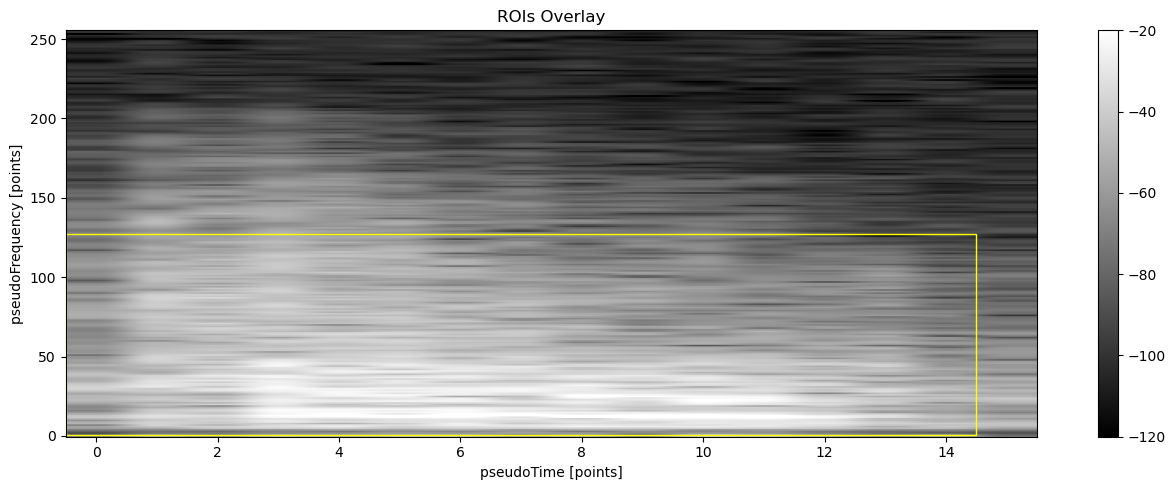

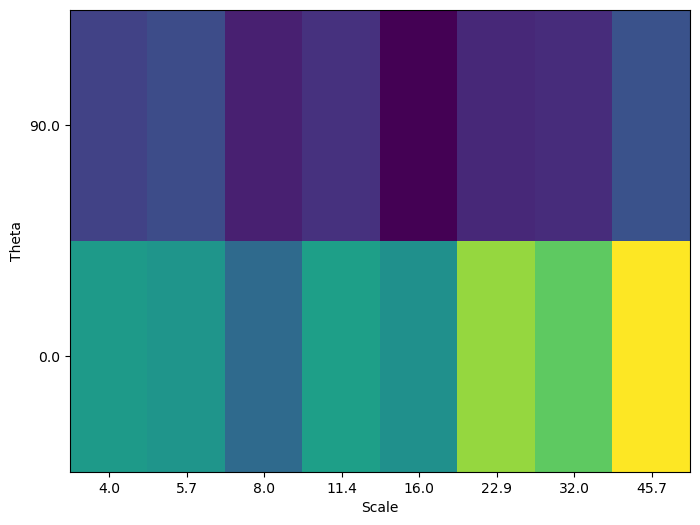

,min_f,min_t,max_f,max_t,min_y,min_x,max_y,max_x,shp_001,shp_002,...,centroid_y,centroid_x,duration_x,bandwidth_y,area_xy,centroid_f,centroid_t,duration_t,bandwidth_f,area_tf
0,50,0.005805,11000.0,0.160907,1,0,128,15,0.073387,0.0753,...,71.0,8.0,127.001542,0,2402,6115.429688,0.088526,0.155102,10938.867188,1696.640625


In [396]:
features.all_shape_features(call["waveform"], call["sr"], rois, display=True, nperseg=512, overlap=512//9)

/Users/lenagies/anaconda3/envs/goose_calls/lib/python3.11/site-packages/maad/util/visualization.py:1094: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  fig.tight_layout()


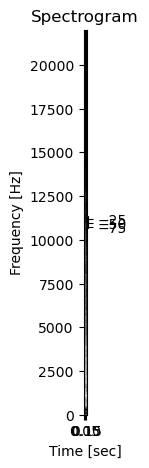

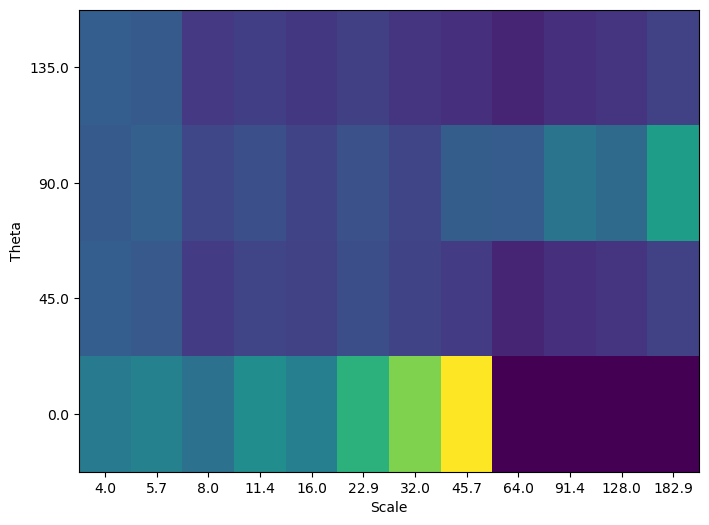

In [397]:
Sxx, tn, fn, ext = sound.spectrogram(call["waveform"], call["sr"], db_range=80, display=True) 
Sxx_db = power2dB(Sxx, db_range=80)
shape, params = features.shape_features(Sxx_db, resolution='med') 
ax = plot_shape(shape.mean(), params) 

Zero pad log-rescaled calls

##### Visualize feature space

##### Analyze spectrograms

In [495]:
def transform(row):
    transformed = librosa.amplitude_to_db(np.abs(librosa.stft(row["padded_signal"], n_fft = n_fft, hop_length=(n_fft//hop_overlap)))**2, ref=np.max)
    #scaled = scale_minmax(transformed, 0, 255).astype(np.uint8)/255. # transform to pixel values and normalize 
    flipped = np.flip(transformed, axis=0) # put low frequencies at the bottom in image
    reduced = flipped[::2, ::2] # reduce to a quarter of the size
    spectrogram = reduced[int(len(reduced)/2.5):, :] # cut out higher energies where no power is left
    # spectrogram = np.abs(spectrogram)

    return row["call_type"], spectrogram

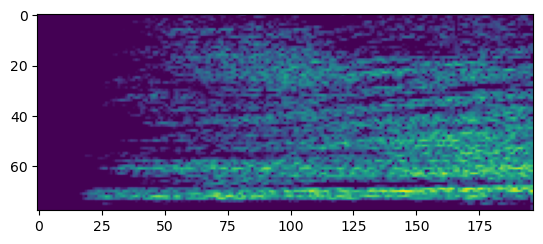

(78, 197)


In [540]:
# longest call
# call = calls_df.loc[calls_df['length'].idxmax()]
# random call
call = calls_df.iloc()[np.random.randint(0, len(calls_df))]

call_type, spectrogram = transform(call)

plt.imshow(spectrogram)
plt.show()
print(spectrogram.shape)